In [11]:
import json
import numpy as np

# Open and load the JSON file
with open("results/logit_result.json", "r") as file:
    data = json.load(file)

# Print the entire JSON content
similarity_matrices = [np.array(entry["similarities"]) for entry in data]  # Convert each to NumPy array
# Stack into a single 3D NumPy array (num_sentences, num_steps, num_layers)
similarity_matrices = np.stack(similarity_matrices, axis=0)
# Compute the mean similarity for each (step, layer) across sentences
average_similarities = np.mean(similarity_matrices, axis=0)

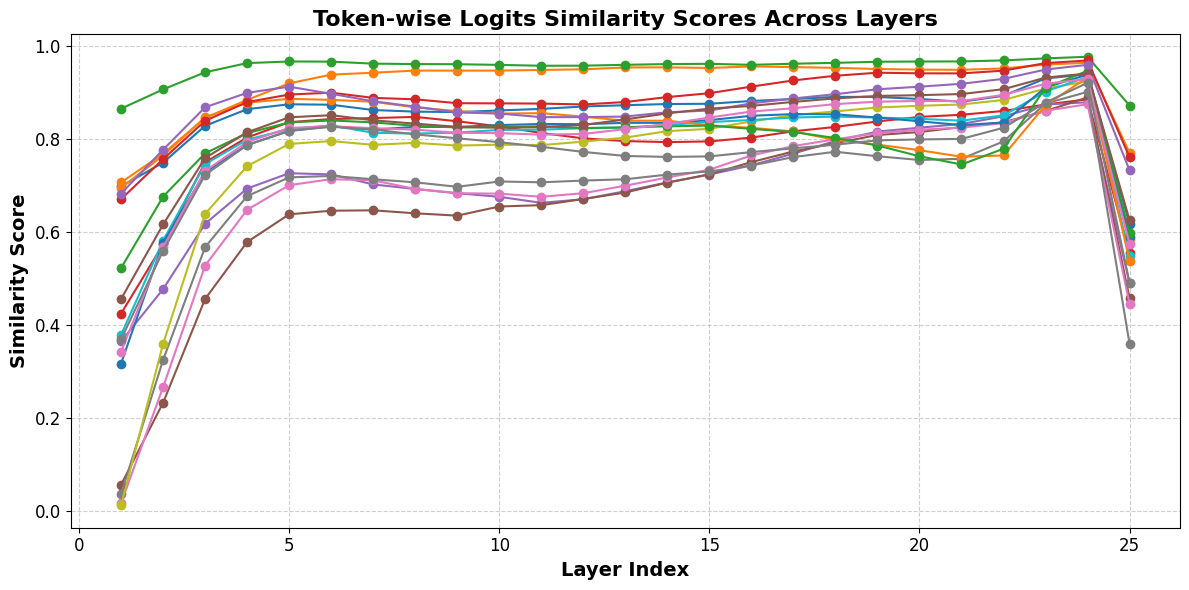

In [13]:
import matplotlib.pyplot as plt
import numpy as np

similarities = average_similarities[2:, :]  # Excludes first two rows (tokens)

# Number of tokens and layers
num_tokens, num_layers = similarities.shape

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each token's similarity score across layers
for token_idx in range(num_tokens):
    plt.plot(range(1, num_layers + 1), similarities[token_idx], marker="o", linestyle="-", label=f"Token {token_idx+1}")

# Styling
plt.xlabel("Layer Index", fontsize=14, fontweight="bold")
plt.ylabel("Similarity Score", fontsize=14, fontweight="bold")
plt.title("Token-wise Logits Similarity Scores Across Layers", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
import json

# Open and load the JSON file
with open("results/flores_results.json", "r") as file:
    flores_data = json.load(file)

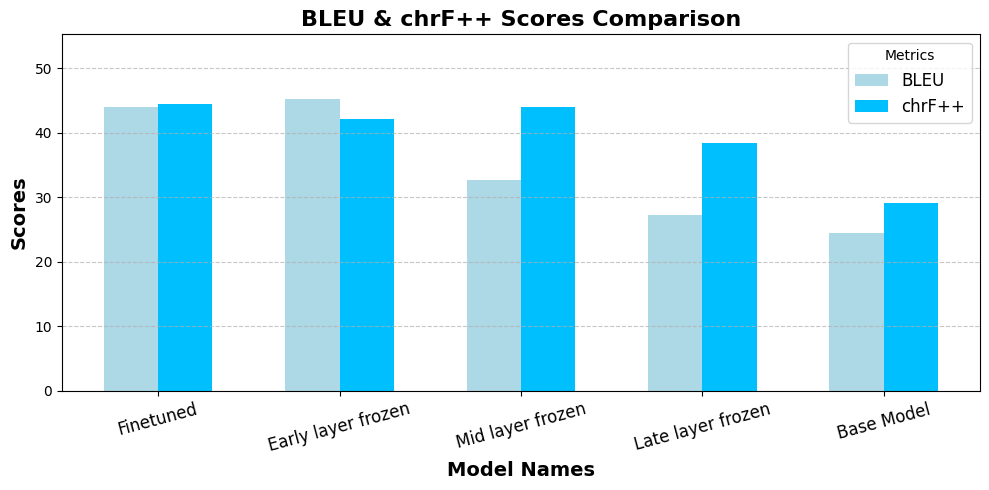

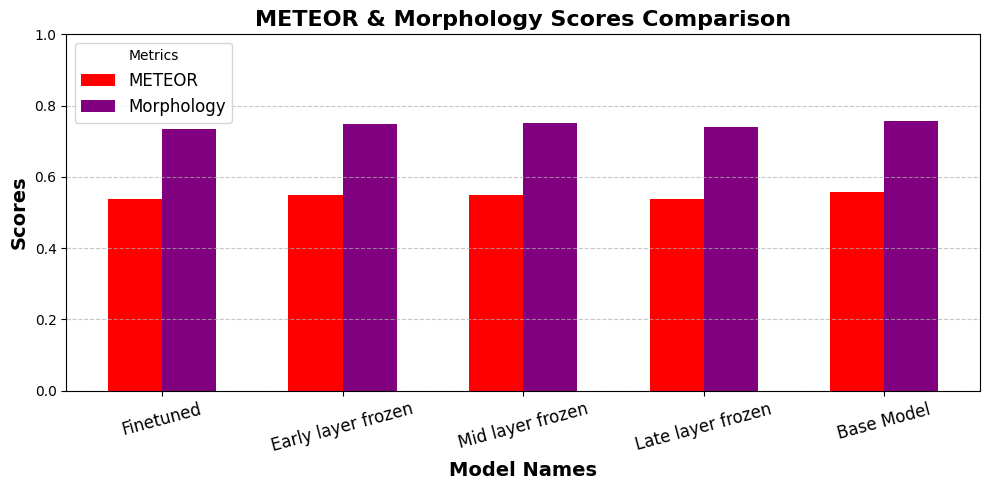

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
models = ["Finetuned", "Early layer frozen", "Mid layer frozen", "Late layer frozen", "Base Model"]  # Model names
numbers = [0, 3, 2, 4, 5]

# Extracting scores
bleu_scores = [flores_data[i]["BLEU"] for i in numbers]
chrf_scores = [flores_data[i]["chrF++"] for i in numbers]
meteor_scores = [flores_data[i]["METEOR"] for i in numbers]
morph_scores = [flores_data[i]["Morph"] for i in numbers]

# Define bar width and positions
x = np.arange(len(models))
bar_width = 0.3

# Create first bar plot (BLEU & chrF++)
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width / 2, bleu_scores, width=bar_width, label="BLEU", color="lightblue")
plt.bar(x + bar_width / 2, chrf_scores, width=bar_width, label="chrF++", color="deepskyblue")

# Formatting for first plot
plt.xlabel("Model Names", fontsize=14, fontweight="bold")
plt.ylabel("Scores", fontsize=14, fontweight="bold")
plt.title("BLEU & chrF++ Scores Comparison", fontsize=16, fontweight="bold")
plt.xticks(ticks=x, labels=models, fontsize=12, rotation=15)
plt.legend(fontsize=12, title="Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, max(max(bleu_scores), max(chrf_scores)) + 10)  # Adjust y-axis limit for better visibility

plt.tight_layout()
plt.show()

# Create second bar plot (METEOR & Morphology)
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width / 2, meteor_scores, width=bar_width, label="METEOR", color="red")
plt.bar(x + bar_width / 2, morph_scores, width=bar_width, label="Morphology", color="purple")

# Formatting for second plot
plt.xlabel("Model Names", fontsize=14, fontweight="bold")
plt.ylabel("Scores", fontsize=14, fontweight="bold")
plt.title("METEOR & Morphology Scores Comparison", fontsize=16, fontweight="bold")
plt.xticks(ticks=x, labels=models, fontsize=12, rotation=15)
plt.legend(fontsize=12, title="Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)  # Adjust y-axis limit for better visibility

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from collections import Counter

def extract_morph_features(sentence):
    """
    Dummy function to extract morphological features.
    In a real setup, use spaCy or a morphological parser for accurate extraction.
    """
    return [{"word": word, "feats": word[-1]} for word in sentence.split()]  # Placeholder

def compare_morph_features(reference, hypothesis):
    """
    Compares the morphological features between the reference and the translated hypothesis.
    """
    ref_features = extract_morph_features(reference)
    hyp_features = extract_morph_features(hypothesis)

    ref_feats_count = Counter([word["feats"] for word in ref_features if word["feats"]])
    hyp_feats_count = Counter([word["feats"] for word in hyp_features if word["feats"]])

    shared_feats = sum((ref_feats_count & hyp_feats_count).values())
    total_feats = sum(ref_feats_count.values())

    morph_similarity = shared_feats / total_feats if total_feats > 0 else 0
    return morph_similarity

def evaluate_morphology(reference_sentences, hypothesis_sentences):
    """
    Evaluates how well the translation preserves morphology across multiple sentences.
    """
    similarities = []
    for ref, hyp in zip(reference_sentences, hypothesis_sentences):
        result = compare_morph_features(ref, hyp)
        similarities.append(result)
    
    avg_similarity = sum(similarities) / len(similarities) if similarities else 0
    return avg_similarity

# Load reference and hypothesis translations
with open("reference_sentences.txt", "r") as ref_file:
    reference_sentences = [line.strip() for line in ref_file.readlines()]

# Assuming flores_results.json contains hypothesis translations
import json
with open("results/flores_results.json", "r") as hyp_file:
    flores_data = json.load(hyp_file)

# Compute morphology scores and update dataset
morph_scores = [
    evaluate_morphology(reference_sentences, flores_data[i]["Predictions"])
    for i in range(len(flores_data))
]

# Extract disabled LoRA information
disabled_lora_layers = [
    flores_data[i].get("Frozen Layers", "None") for i in range(len(flores_data))
]

# Update DataFrame
data = {
    "Model": [
        f"{flores_data[i]['Model Name']}" for i in range(len(flores_data))
    ],
    "Disabled_LoRA_Layers": disabled_lora_layers,
    "BLEU": [flores_data[i]["BLEU"] for i in range(len(flores_data))],
    "chrF++": [flores_data[i]["chrF++"] for i in range(len(flores_data))],
    "METEOR": [flores_data[i]["METEOR"] for i in range(len(flores_data))],
    "Morphology": morph_scores
}

df = pd.DataFrame(data)

In [ ]:
df.to_csv("results/updated_flores_results.csv", index=False)

In [38]:
df

,Model,Disabled_LoRA_Layers,BLEU,chrF++,METEOR,Morphology
0,Billyyy/mon_nllb_3B,None,44.058638,44.426093,0.537257,0.723010
1,Billyyy/mon_nllb_3B_r32,None,45.298529,42.123201,0.535382,0.722338
2,Billyyy/mon_nllb_3B,middle,32.666948,43.944077,0.550242,0.734200
3,Billyyy/mon_nllb_3B,early,45.298529,42.123201,0.548596,0.736881
4,Billyyy/mon_nllb_3B,late,27.249745,38.391527,0.537745,0.724588
5,base_model,none,24.446151,29.048680,0.556373,0.739840
6,Billyyy/mon_nllb_3B_r32,middle,45.298529,42.123201,0.543534,0.728882
7,Billyyy/mon_nllb_3B_r32,late,27.249745,38.391527,0.533462,0.722921
8,Billyyy/mon_nllb_3B_r32,early,45.298529,42.123201,0.547848,0.732970
9,Billyyy/mon_nllb_3B_r32,last_2,39.688581,40.794066,0.533480,0.719875
